# Data compression throug Singular Value Decomposition (SVD)

In this tutorial we will see how we can compress information through SVD.
In order to do so we need the Images.jl package of Julia (https://juliaimages.org/latest/install/#sec_visualization).

We will practice on an image located in Img/03/Marienplatz.jpg.

In [ ]:
# First of all, load Images, Linear algebra and PyPlot

using Images, LinearAlgebra, PyPlot, Random

In [ ]:
# Then load the image. Julia notebooks should automatically display it (remove the semicolumn ;)

img_path = "../Img/03/Marienplatz.jpg"
M = load(img_path);

In [ ]:
# Get the size of M in megabytes
size = round(Base.summarysize(M)*10^(-6); digits=2);
#Get the type of M
tp   = typeof(M);

println("M is stored as $tp")
println("The size of M is $size Mb")

In [ ]:
# Convert M into an array of Float64 (double precision)
M2 = convert(Array{Float64},M);
# In order to display it with gray scale we now use (remove the semicolumn ;)
Gray.(M2);

In [ ]:
# We can check the new type and dimension of M2
# Get the size of M2 in megabytes
size = round(Base.summarysize(M2)*10^(-6); digits=2);
#Get the type of M2
tp   = typeof(M2);

println("M2 is stored as $tp")
println("The size of M2 is $size Mb")

### SVD of the image

First of all we will need to perform SVD on M2 and we will study the behaviour of the singular values

In [ ]:
U, S, V = svd(M2);

In [ ]:
# We can plot the singular values in order to see the exponential decay.

title("Singular values")
xMin = 0.0;
yMin = 0.0;
xMax = 3500;
yMax = 3000;
dx = 500;
dy = 500;
xlim(xMin,xMax);
ylim(yMin,yMax);
xticks(xMin:dx:xMax);
yticks(yMin:dy:yMax);
ylabel("Magnitude");
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(S,linewidth=3.0,color="red")

### Singular value compression of the image

Now we will take into account only a portion of the singular values and see up to which degree they are relevant for a proper rendering.

In [ ]:
# Keep only the first 10 singular values

A = U[:,1:10]*Diagonal(S[1:10])*V[:,1:10]';
Gray.(A);

In [ ]:
# Keep only the first 30 singular values

A = U[:,1:30]*Diagonal(S[1:30])*V[:,1:30]';
Gray.(A);

In [ ]:
# Keep only the first 100 singular values

A = U[:,1:100]*Diagonal(S[1:100])*V[:,1:100]';
Gray.(A);

In [ ]:
# Keep only the first 300 singular values

A = U[:,1:300]*Diagonal(S[1:300])*V[:,1:300]';
Gray.(A);

We can clearly see that with only 300 singular values we can reconstruct the image (quite) accurately, therefore with a reduction to the 10% of the total number of singular values.

# SVD in tensor diagrams

The transformation of matrix product states (MPS) into the various canonical forms can be achieved via SVD.
Indeed, as we have seen in Tutorial 02, the multiplication of rank-2 tensors (i.e. matrices) can be represented as tensor contractions. In this view, the SVD of a matrix is seen as the contraction of three rank-2 tensors:

![title](../Img/03/03_01.png)

Recall that:

- T = USV<sup>+</sup>
- U<sup>+</sup>U = I
- v<sup>+</sup>V = I

### Note: setting the seed for random number generation

We can set the seed at the beginning of the computation in order to have the same result everytime we restart the computation from the beginning. This is done with the following command:

In [1]:
using LinearAlgebra, Random, PyPlot

# Initialize seed

Random.seed!(1234);

In [2]:
# Importing the contraction module
include("../Tensor_modules/contract.jl");

## Generate random MPS

As initial step we generate an MPS formed by N rank-3 tensors:

![title](../Img/03/03_02.png)

Note that the first and the last MPS have a dummy leg, this is done to ensure that every single matrix M is a rank-3 tensor.

In [3]:
## Initialization
# Number of sites
N = 50;
# Physical bond dimension
d = 3;
# Virtual bond dimension
D = 30;

# Initializing the Tensors
M = Vector{Union{Nothing, Array{Float64,3}}}(nothing, N); # Collection of N rank-3 tensors initialized to 'nothing'
# Initialize norm_MPS
norm_MPS = 0.0;

# Assign random tensors. The order of the dimension is left-bottom-right
for i in 1:N
    if i==1
        # First tensor has left dummy leg
        M[i] = rand(1,d,D);
    elseif i==N
        # Last tensor has right dummy leg
        M[i] = rand(D,d,1);
    else
        # Central tensors
        M[i] = rand(D,d,D);
    end
end

### Iterative transformation to LC

We start from the leftmost site and we go to the rightmost iteratively applying the SVD. In particular, at the n-th step:

M*M' = USV<sup>+</sup>M' = AM''

where A = U and M'' = SV<sup>+</sup>M'. The new matrix A is left normalized because U is: A<sup>+</sup>A = U<sup>+</sup>U .

In order to do so:\
1) Reshape M(D,d,D) so that it is a matrix M(D*d,D);\
2) Apply SVD to M(D*d,D);\
3) A = reshape U;\
4) Obtain M'' by contracting SVM'\

The SVD of the last tensor M{N} results in one singular value and one right singular vector (that has
one element). The singular value is the norm of the MPS. And the right singular vector is an overall phase factor which does not change the physical content of quantum state.

In [4]:
for i in 1:N
    T = M[i];
    T = reshape(T, (size(T,1)*size(T,2), size(T,3)));
    U,S,V = svd(T);
    M[i] = reshape(U,(convert(Int,size(U,1)/size(M[i],2)), size(M[i],2), size(U,2)));
    if i < N
            M[i+1] = contract(Diagonal(S)*V',2,2,M[i+1],3,1);
    end
    if i == N
        norm_MPS = S;
    end
end

In [5]:
# We can then check the norm of the MPS by printing the last singular value

println("Norm of MPS = $norm_MPS")

Norm of MPS = [1.4728400250365303e69]


We have obtained a normalized left-canonical MPS:

![title](../Img/03/03_03.png)

### Iterative transformation to RC

We start from the rightmost site to the leftmost site iteratively applying the SVD. In particular, at the n-th step:

M*M' = MUSV<sup>+</sup> = M''B

where B = V<sup>+</sup> and M'' = MUS. The new matrix B is right normalized because V<sup>+</sup> is: BB<sup>+</sup> = V<sup>+</sup>V .

The difference with respect to the LC is that the direction of the arrows is reversed. Nevertheless, since we are not taking into account any symmetry up to now, this doesn't modify any computational step: the reverse of the arrow direction is just a way of keeping in mind how the tensors need to be contracted.

The steps are the following:\
1) Reshape the last M(D,d,D) so that it is a matrix M(D,d*D);\
2) Apply SVD to M(D,d*D);\
3) B = reshape V<sup>+</sup>;\
4) Obtain M'' by contracting MUS\

In [6]:
for i in N:-1:1

   T = M[i];
      T = reshape(T, (size(T,1), size(T,2)*size(T,3)));
      U,S,V = svd(T);
      M[i] = reshape(V', (size(V,2), size(M[i],2), convert(Int,size(V,1)/size(M[i],2))));
    if i > 1
        M[i-1] = contract(M[i-1],3,3,U*Diagonal(S),2,1);
    end
    if i == 1
        norm_MPS = S;
    end
end

In [7]:
# We can then check the norm of the MPS by printing the last singular value

println("Norm of MPS = $norm_MPS")

Norm of MPS = [0.9999999999999979]


We have now obtained a right-canonical MPS. Morevoer, since we have started from a previously normalized MPS, the norm of the new RC MPS is 1.

### Module canonForm.jl

We have included all the above steps into a new module, canonForm.jl, which brings a given MPS into left-, right- or bond-canonical form.

In order to do so we can call:

 M,S,dw = canonForm(M,id [,Nkeep]);

As input we give M and the index for the bond connecting the tensors M[id] and M[id+1]. With respect to the bond, the tensors to the left (right) are brought into the left-(right-)canonical form. If id == 0, the whole MPS will be in the right-canonical form.

As an option, Nkeep keeps only the first Nkeep-ths singular values and their associated singular vectors at each iteration.

For further information you can use ?.

In [8]:
# Load the module
include("../Tensor_modules/canonForm.jl");

In [9]:
? canonForm

search: canonForm



M,S,dw = canonForm(M,id [,Nkeep]);

Obtain the canonical forms of MPS. It brings the tensors M{1}, ..., M{id}  into the left-canonical form and the others M{id+1}, ..., M{end} into the  right-canonical form.

< Input >  M : [cell array] MPS of length numel(M). Each cell element is a rank-3        tensor, where the first, second, and third dimensions are        associated with left, bottom (i.e., local), and right legs,        respectively.  id : [integer] Index for the bond connecting the tensors M{id} and        M{id+1}. With respect to the bond, the tensors to the left        (right) are brought into the left-(right-)canonical form. If id ==        0, the whole MPS will be in the right-canonical form.

< Option >  Nkeep : [integer] Maximum bond dimension. That is, only Nkeep the        singular values and their associated singular vectors are kept at        each iteration.

< Output >  M : [cell array] Left-, right-, or bond-canonical form from input M,        depending on id, as follows:        * id == 0: right-canonical form        * id == numel(M): left-canonical form        * otherwise: bond-canonical form  S : [column vector] Singular values at the bond between M{id} and M{id+1}.   dw : [column vector] Vector of length numel(M)-1. dw(n) means the        discarded weight (i.e., the sum of the square of the singular          values that are discarded) at the bond between M{n} and M{n+1}.

Written by S.Lee (Apr.30,2019)  Julia version by D. Romanin (November 4, 2020)


In order to show that it works, we redo the precedent steps using this module.

In [10]:
# Reset the seed
Random.seed!(1234);

## Re-initialize the MPS
# Number of sites
N = 50;
# Physical bond dimension
d = 3;
# Virtual bond dimension
D = 30;

# Initializing the Tensors
M = Vector{Union{Nothing, Array{Float64,3}}}(nothing, N); # Collection of N rank-3 tensors initialized to 'nothing'
# Initialize norm_MPS
norm_MPS = 0.0;

# Assign random tensors. The order of the dimension is left-bottom-right
for i in 1:N
    if i==1
        # First tensor has left dummy leg
        M[i] = rand(1,d,D);
    elseif i==N
        # Last tensor has right dummy leg
        M[i] = rand(D,d,1);
    else
        # Central tensors
        M[i] = rand(D,d,D);
    end
end

In [11]:
# Bring to left-canonical by keeping all the singular values
M, S, D = canonForm(M,length(M));

# Check that the norm is as the one we computed in the precedent steps
println("The norm of the LC MPS is $S")

The norm of the LC MPS is [1.4728400250365303e69]


In [12]:
# Bring to right-canonical by keeping all the singular values
M, S, D = canonForm(M,0);

# Check that the norm is as the one we computed in the precedent steps
println("The norm of the LC MPS is $S")

The norm of the LC MPS is [0.9999999999999979]


Everything works up to now.

We now transform again to LC by discarding different numbers of singular values and see what happens to the norm.

In [13]:
Nkeeps = 5:30; # Different values of kept singular values

Ss = zeros(length(Nkeeps),1); # Vector that will contain the norm as a function of Nkeep

A = M[:]; # Copy M, so that it won't get overwritten

for i in 1:length(Nkeeps)
    M = A[:];
    T, S, D = canonForm(M,length(M),Nkeeps[i])
    Ss[i] = norm(S);
end

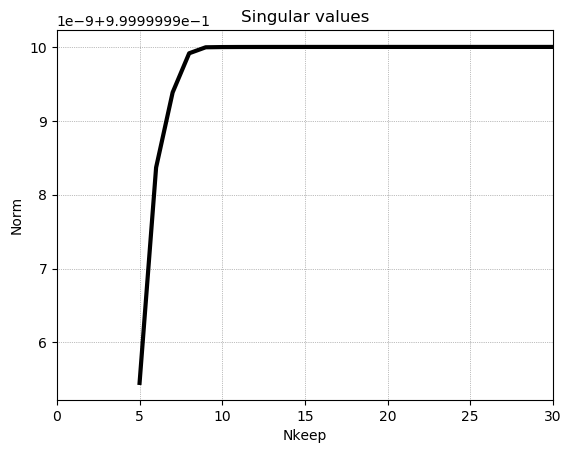

In [14]:
# Now plot the norm as a function of Nkeep

title("Singular values")
xMin = 0.0;
xMax = 30;
dx = 5;
xlim(xMin,xMax);
xticks(xMin:dx:xMax);
ylabel("Norm");
xlabel("Nkeep")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(Nkeeps,Ss,linewidth=3.0,color="black");

The norm almost does not change. If you print S at each iteration, you will see that the largest singular value is almost unity, and the other singular values are much smaller than the largest one. Therefore, the truncation of such small singular values and their associated singular vectors barely affects the result.

We now start from the right-canonical MPS and bring it again to RC by truncating some singular values.

In [15]:
Ss = zeros(length(Nkeeps),1); # Vector that will contain the norm as a function of Nkeep

for i in 1:length(Nkeeps)
    M = A[:];
    T, S, D = canonForm(M,0,Nkeeps[i])
    Ss[i] = norm(S);
end

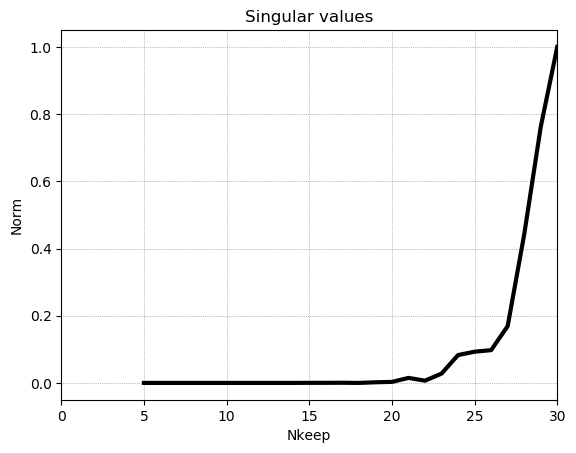

In [16]:
# Now plot the norm as a function of Nkeep

title("Singular values")
xMin = 0.0;
xMax = 30;
dx = 5;
xlim(xMin,xMax);
xticks(xMin:dx:xMax);
ylabel("Norm");
xlabel("Nkeep")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(Nkeeps,Ss,linewidth=3.0,color="black");

The norm decreases exponentially, with decreasing Nkeep.Indeed, in the input M, all the tensors are already right-normalized, that is they are equivalent to the unitary matrices. The singular values of the unitary matrices are unity! So the truncation of such singular values result in the loss of information.

Now we bring it to bond-canonical form, say at site 25.

In [17]:
Ss = zeros(length(Nkeeps),1); # Vector that will contain the norm as a function of Nkeep

for i in 1:length(Nkeeps)
    M = A[:];
    T, S, D = canonForm(M,25,Nkeeps[i])
    Ss[i] = norm(S);
end

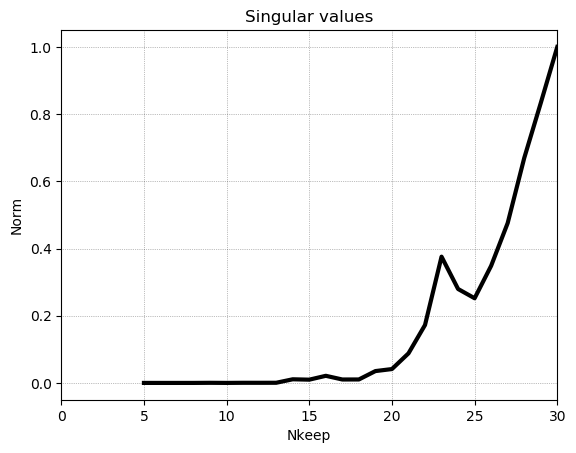

In [18]:
# Now plot the norm as a function of Nkeep

title("Singular values")
xMin = 0.0;
xMax = 30;
dx = 5;
xlim(xMin,xMax);
xticks(xMin:dx:xMax);
ylabel("Norm");
xlabel("Nkeep")
grid(linewidth=0.5,color="black",linestyle="dotted",alpha=0.5);
plot(Nkeeps,Ss,linewidth=3.0,color="black");

The norm also decreases exponentially with decreasing Nkeep. It is because the right half of the MPS is brought again into the right-canonical form, with truncating large singular values.